### BPT Diagram Analysis for NGC 1399 ###

Este notebook realiza uma análise científica robusta do cubo espectral IFU da galáxia NGC 1399. Inclui correção de extinção via decremento de Balmer, máscaras de S/N, ajustes simultâneos de linhas de emissão, cálculo de incertezas e produção de mapas e diagramas prontos para publicação.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from typing import Tuple, Dict

def gaussian(x: np.ndarray, amp: float, cen: float, sigma: float) -> np.ndarray:
    """Gaussiana simples."""
    return amp * np.exp(-0.5 * ((x - cen) / sigma) ** 2)

def three_gaussians(x: np.ndarray, A1: float, c1: float, s1: float,
                    A2: float, c2: float, s2: float,
                    A3: float, c3: float, s3: float) -> np.ndarray:
    """Soma de 3 gaussianas, para linhas próximas."""
    return (gaussian(x, A1, c1, s1) +
            gaussian(x, A2, c2, s2) +
            gaussian(x, A3, c3, s3))

def extract_flux_single_line(spectrum: np.ndarray, wavelengths: np.ndarray,
                             center_wl: float, window: int = 10) -> float:
    """
    Extrai fluxo de linha por ajuste gaussiano simples em uma janela ao redor do centro.
    Retorna fluxo integrado ou NaN se falhar.
    """
    idx_center = np.argmin(np.abs(wavelengths - center_wl))
    idx_min = max(idx_center - window, 0)
    idx_max = min(idx_center + window, len(wavelengths) - 1)

    x = wavelengths[idx_min:idx_max+1]
    y = spectrum[idx_min:idx_max+1]

    # Continua só se espectro válido
    if np.all(np.isnan(y)) or np.nanmax(y) <= 0:
        return np.nan

    # Palpite inicial
    p0 = [np.nanmax(y), center_wl, 2.0]
    try:
        popt, _ = curve_fit(gaussian, x, y, p0=p0, bounds=(0, np.inf), maxfev=1000)
        amp, cen, sigma = popt
        fluxo = amp * sigma * np.sqrt(2 * np.pi)
        return fluxo
    except Exception:
        return np.nan

def extract_flux_triple_lines(spectrum: np.ndarray, wavelengths: np.ndarray,
                              centers: Tuple[float, float, float], window: int = 15) -> Tuple[float, float, float]:
    """
    Ajusta 3 gaussianas simultaneamente para extrair fluxes das linhas próximas.
    Retorna tupla (fluxo_linha1, fluxo_linha2, fluxo_linha3) ou NaNs.
    """
    center_main = centers[1]  # geralmente Hα
    idx_center = np.argmin(np.abs(wavelengths - center_main))
    idx_min = max(idx_center - window, 0)
    idx_max = min(idx_center + window, len(wavelengths) - 1)

    x = wavelengths[idx_min:idx_max+1]
    y = spectrum[idx_min:idx_max+1]

    if np.all(np.isnan(y)) or np.nanmax(y) <= 0:
        return np.nan, np.nan, np.nan

    # Palpites iniciais: amplitudes iguais dividindo max, centros conhecidos, sigma 2.0
    max_amp = np.nanmax(y)
    p0 = [
        max_amp/3, centers[0], 2.0,
        max_amp/3, centers[1], 2.0,
        max_amp/3, centers[2], 2.0,
    ]

    try:
        popt, _ = curve_fit(three_gaussians, x, y, p0=p0, bounds=(0, np.inf), maxfev=2000)
        flux1 = popt[0] * popt[2] * np.sqrt(2 * np.pi)
        flux2 = popt[3] * popt[5] * np.sqrt(2 * np.pi)
        flux3 = popt[6] * popt[8] * np.sqrt(2 * np.pi)
        return flux1, flux2, flux3
    except Exception:
        return np.nan, np.nan, np.nan

def classify_bpt(log_n2_ha: float, log_o3_hb: float) -> int:
    """
    Classificação BPT para um ponto baseado nas curvas Kewley+01 e Kauffmann+03.
    Retorna código:
    0 = HII (formação estelar)
    1 = Composto
    2 = AGN (Seyfert + LINER)
    3 = Desconhecido/Inválido
    """
    if np.isnan(log_n2_ha) or np.isnan(log_o3_hb):
        return 3

    kewley = 0.61 / (log_n2_ha - 0.47) + 1.19
    kauffmann = 0.61 / (log_n2_ha - 0.05) + 1.3

    if log_o3_hb > kewley:
        return 2
    elif log_o3_hb > kauffmann:
        return 1
    else:
        return 0

# --------------------------
# --- Aplicação no cubo ---

filename = '../ggrNGC1399.fits'

with fits.open(filename) as hdul:
    cube = hdul[0].data  # shape: (lambda, y, x)
    header = hdul[0].header

n_wave, ny, nx = cube.shape
crval = header['CRVAL3']
cdelt = header['CDELT3']
crpix = header['CRPIX3']

wavelengths = crval + (np.arange(n_wave) + 1 - crpix) * cdelt

# Redshift da galáxia
z = 0.00475

# Centros ajustados para linhas (corrigidos para redshift)
centers_triple = tuple(np.array([6548.1, 6562.8, 6583.4]) * (1 + z))
centers_simple = {
    "Hb": 4861.3 * (1 + z),
    "OIII": 5006.8 * (1 + z)
}

# Inicializar mapas de fluxo
flux_Hb = np.full((ny, nx), np.nan)
flux_OIII = np.full((ny, nx), np.nan)
flux_NII_6548 = np.full((ny, nx), np.nan)
flux_Ha = np.full((ny, nx), np.nan)
flux_NII_6583 = np.full((ny, nx), np.nan)

print("Extraindo fluxos do cubo...")

for y in range(ny):
    for x in range(nx):
        spec = cube[:, y, x]

        # Tripla gaussiana para [NII]6548, Hα, [NII]6583
        f1, f2, f3 = extract_flux_triple_lines(spec, wavelengths, centers_triple)
        flux_NII_6548[y, x] = f1
        flux_Ha[y, x] = f2
        flux_NII_6583[y, x] = f3

        # Linhas simples
        flux_Hb[y, x] = extract_flux_single_line(spec, wavelengths, centers_simple["Hb"])
        flux_OIII[y, x] = extract_flux_single_line(spec, wavelengths, centers_simple["OIII"])

print("Fluxos extraídos!")

# Calcular razões logarítmicas
with np.errstate(divide='ignore', invalid='ignore'):
    flux_NII_total = flux_NII_6548 + flux_NII_6583
    log_n2_ha = np.log10(flux_NII_total / flux_Ha)
    log_o3_hb = np.log10(flux_OIII / flux_Hb)

# Máscara para valores válidos
mask_valid = np.isfinite(log_n2_ha) & np.isfinite(log_o3_hb)

# Criar mapa de classificação BPT
bpt_map = np.full((ny, nx), 3, dtype=int)  # Inicializa com 'Desconhecido'

for y in range(ny):
    for x in range(nx):
        if mask_valid[y, x]:
            bpt_map[y, x] = classify_bpt(log_n2_ha[y, x], log_o3_hb[y, x])




Extraindo fluxos do cubo...
Fluxos extraídos!


36m 30.8s

In [21]:
print(f"CRVAL3 = {crval}, CDELT3 = {cdelt}, CRPIX3 = {crpix}")

CRVAL3 = 4228.805, CDELT3 = 0.462598, CRPIX3 = 1.0


CRVAL3 = 4228.805
CDELT3 = 0.462598
CRPIX3 = 1.0

Número de canais espectrais: 6253
Primeiros 10 valores de wavelengths (Å):
[4228.805    4229.267598 4229.730196 4230.192794 4230.655392 4231.11799
 4231.580588 4232.043186 4232.505784 4232.968382]
Últimos 10 valores de wavelengths (Å):
[7116.804314 7117.266912 7117.72951  7118.192108 7118.654706 7119.117304
 7119.579902 7120.0425   7120.505098 7120.967696]


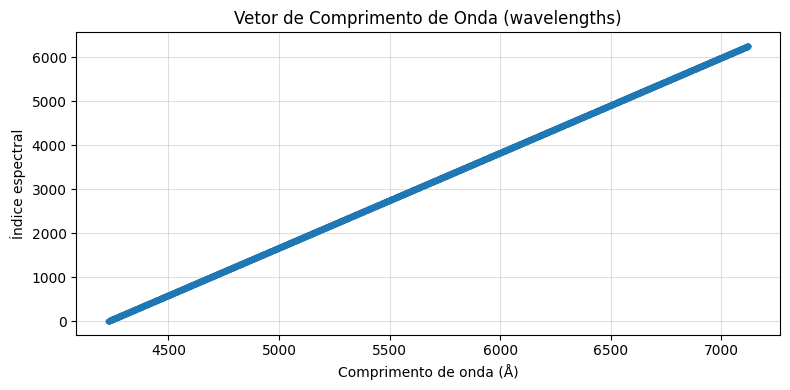

In [22]:
import matplotlib.pyplot as plt

print(f"CRVAL3 = {crval}")
print(f"CDELT3 = {cdelt}")
print(f"CRPIX3 = {crpix}")

print(f"\nNúmero de canais espectrais: {n_wave}")
print(f"Primeiros 10 valores de wavelengths (Å):\n{wavelengths[:10]}")
print(f"Últimos 10 valores de wavelengths (Å):\n{wavelengths[-10:]}")

plt.figure(figsize=(8, 4))
plt.plot(wavelengths, np.arange(n_wave), marker='o', linestyle='-', markersize=3)
plt.xlabel("Comprimento de onda (Å)")
plt.ylabel("Índice espectral")
plt.title("Vetor de Comprimento de Onda (wavelengths)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


Imagem salva: mapa_bpt_masked.png


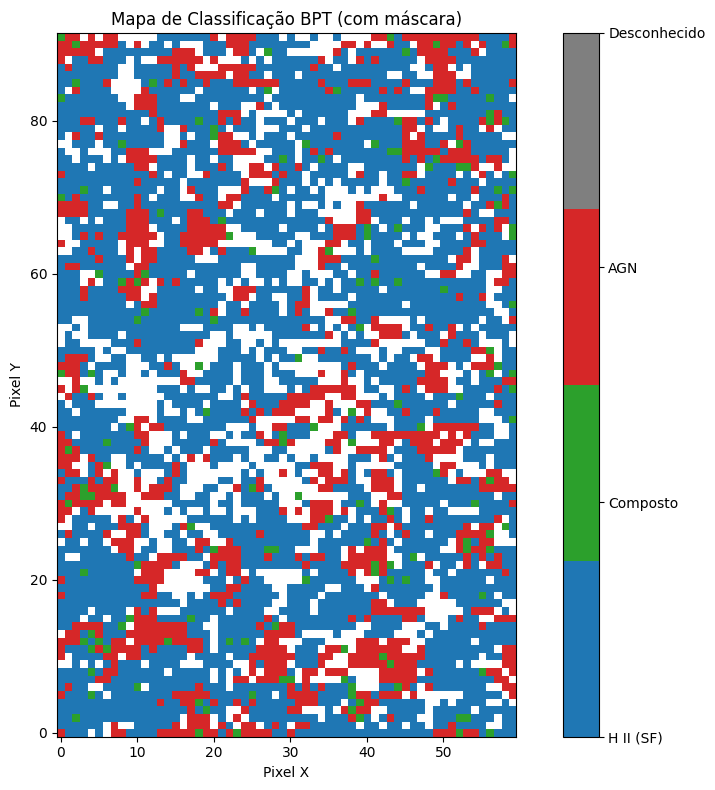

Imagem salva: diagrama_bpt_classes.png


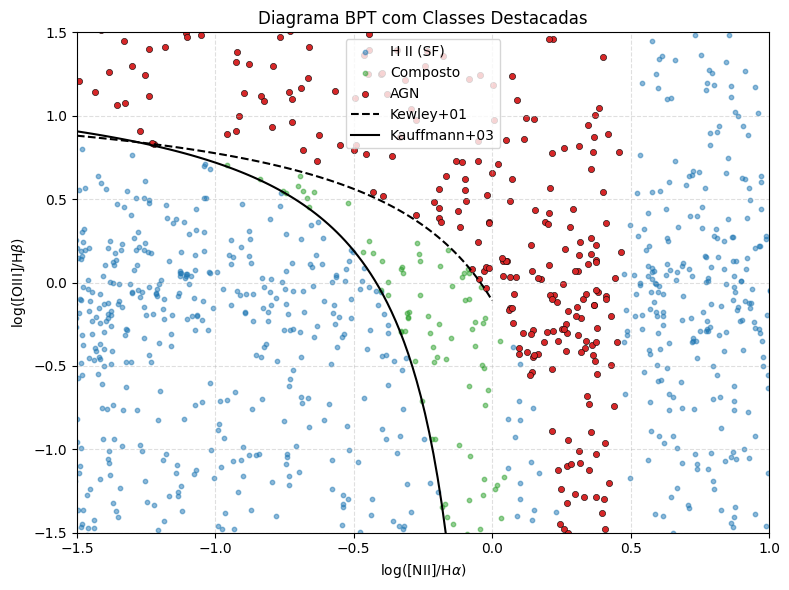

Imagem salva: imagem_integrada_cubo.png


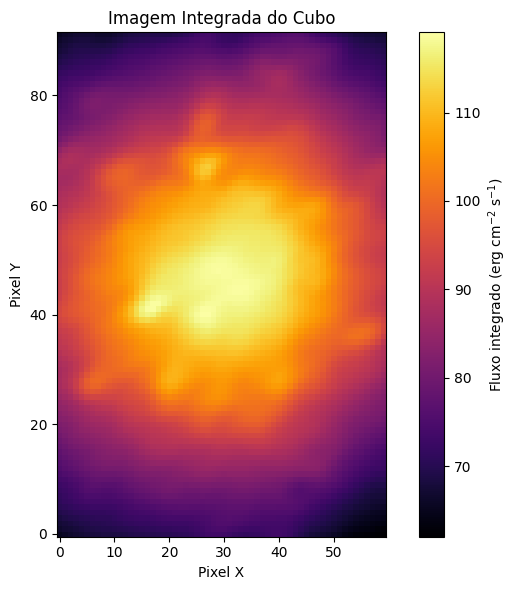

Imagem salva: canal_espectral_3126.png


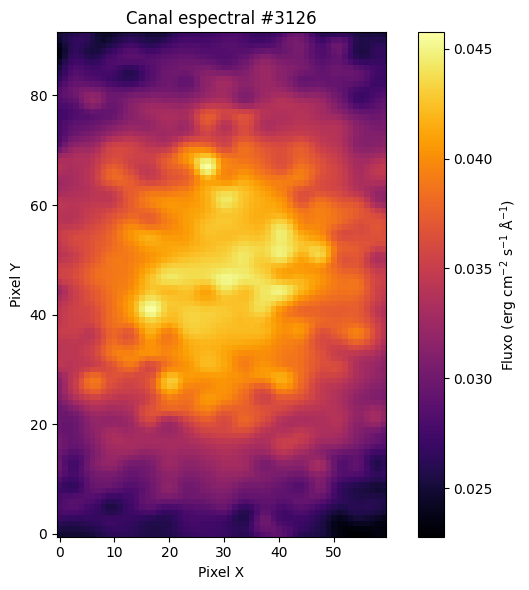

Imagem salva: espectro_pixel_50_50.png


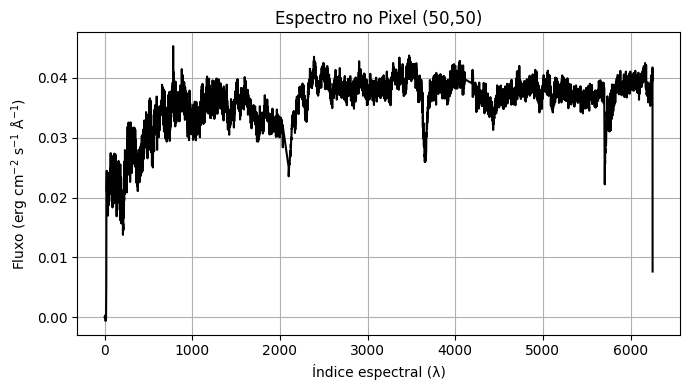

Imagem salva: mapa_bpt_sobre_imagem_integrada.png


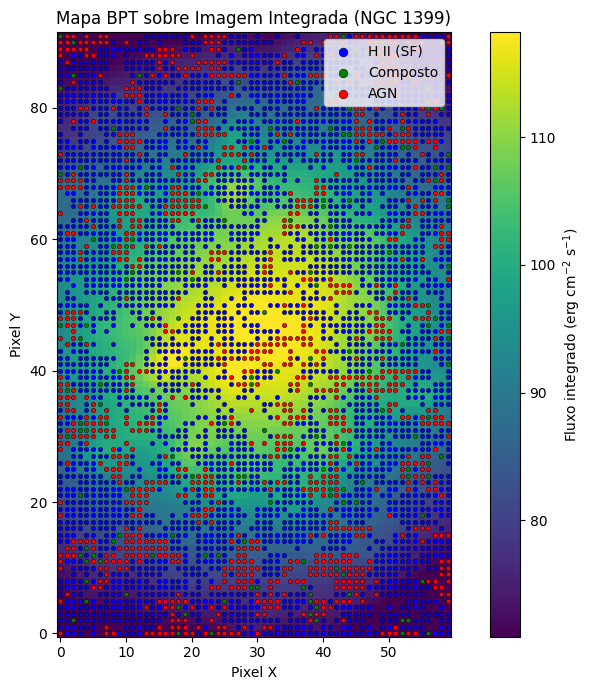

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from astropy.io import fits

def save_and_show_fig(filename):
    plt.savefig(filename, dpi=150)
    print(f"Imagem salva: {filename}")
    plt.show()
    plt.close()

# Parte 1 - Visualização do mapa BPT com máscara
def plot_bpt_masked(bpt_map, mask_valid):
    bpt_masked = bpt_map.astype(float).copy()
    bpt_masked[~mask_valid] = np.nan

    colors = ['#1f77b4', '#2ca02c', '#d62728', '#7f7f7f']  # azul, verde, vermelho, cinza
    labels = ['H II (SF)', 'Composto', 'AGN', 'Desconhecido']
    cmap = ListedColormap(colors)

    plt.figure(figsize=(10, 8))
    im = plt.imshow(bpt_masked, origin='lower', cmap=cmap, vmin=0, vmax=3)
    cbar = plt.colorbar(im, ticks=[0,1,2,3])
    cbar.ax.set_yticklabels(labels)
    plt.title('Mapa de Classificação BPT (com máscara)')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.tight_layout()

    save_and_show_fig('mapa_bpt_masked.png')

# Parte 2 - Diagrama BPT com classes destacadas
def plot_bpt_diagram(log_n2_ha, log_o3_hb, bpt_map, mask_valid, x_kewley, kewley_curve, x_kauff, kauffmann_curve):
    mask_sf = (bpt_map == 0) & mask_valid
    mask_comp = (bpt_map == 1) & mask_valid
    mask_agn = (bpt_map == 2) & mask_valid

    plt.figure(figsize=(8,6))
    plt.scatter(log_n2_ha[mask_sf], log_o3_hb[mask_sf], c='#1f77b4', s=10, alpha=0.5, label='H II (SF)')
    plt.scatter(log_n2_ha[mask_comp], log_o3_hb[mask_comp], c='#2ca02c', s=10, alpha=0.5, label='Composto')
    plt.scatter(log_n2_ha[mask_agn], log_o3_hb[mask_agn], c='#d62728', s=20, edgecolors='k', linewidth=0.4, label='AGN')

    plt.plot(x_kewley, kewley_curve, 'k--', label='Kewley+01')
    plt.plot(x_kauff, kauffmann_curve, 'k-', label='Kauffmann+03')

    plt.xlabel(r'$\log([\mathrm{NII}]/\mathrm{H}\alpha)$')
    plt.ylabel(r'$\log([\mathrm{OIII}]/\mathrm{H}\beta)$')
    plt.title('Diagrama BPT com Classes Destacadas')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xlim(-1.5, 1.0)
    plt.ylim(-1.5, 1.5)
    plt.legend(loc='best', frameon=True)
    plt.tight_layout()

    save_and_show_fig('diagrama_bpt_classes.png')

# Parte 3 - Imagem integrada do cubo
def plot_img_integrada(cube, delta_lambda):
    img_integrada = np.nansum(cube, axis=0) * delta_lambda

    plt.figure(figsize=(7,6))
    plt.imshow(img_integrada, origin='lower', cmap='inferno')
    plt.colorbar(label="Fluxo integrado (erg cm$^{-2}$ s$^{-1}$)")
    plt.title("Imagem Integrada do Cubo")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.tight_layout()

    save_and_show_fig('imagem_integrada_cubo.png')

# Parte 4 - Canal espectral específico
def plot_canal_espectral(cube, canal_idx):
    plt.figure(figsize=(7,6))
    plt.imshow(cube[canal_idx, :, :], origin='lower', cmap='inferno')
    plt.colorbar(label="Fluxo (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)")
    plt.title(f"Canal espectral #{canal_idx}")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.tight_layout()

    save_and_show_fig(f'canal_espectral_{canal_idx}.png')

# Parte 5 - Espectro em pixel específico
def plot_espectro_pixel(cube, x0, y0):
    espectro = cube[:, y0, x0]

    plt.figure(figsize=(7,4))
    plt.plot(espectro, color='k')
    plt.title(f"Espectro no Pixel ({x0},{y0})")
    plt.xlabel("Índice espectral (λ)")
    plt.ylabel("Fluxo (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)")
    plt.grid(True)
    plt.tight_layout()

    save_and_show_fig(f'espectro_pixel_{x0}_{y0}.png')

# Parte 6 - Mapa BPT sobreposto à imagem integrada
def plot_bpt_overlay(img_integrada, bpt_map, mask_valid):
    mask_sf = (bpt_map == 0) & mask_valid
    mask_comp = (bpt_map == 1) & mask_valid
    mask_agn = (bpt_map == 2) & mask_valid

    plt.figure(figsize=(8,7))
    vmin = np.percentile(img_integrada, 5)
    vmax = np.percentile(img_integrada, 99)
    im = plt.imshow(img_integrada, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im)
    cbar.set_label("Fluxo integrado (erg cm$^{-2}$ s$^{-1}$)")

    y_sf, x_sf = np.where(mask_sf)
    y_comp, x_comp = np.where(mask_comp)
    y_agn, x_agn = np.where(mask_agn)

    plt.scatter(x_sf, y_sf, s=10, c='blue', edgecolors='k', linewidth=0.3, label='H II (SF)')
    plt.scatter(x_comp, y_comp, s=10, c='green', edgecolors='k', linewidth=0.3, label='Composto')
    plt.scatter(x_agn, y_agn, s=10, c='red', edgecolors='k', linewidth=0.3, label='AGN')

    plt.title("Mapa BPT sobre Imagem Integrada (NGC 1399)")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.legend(markerscale=2, loc='upper right', frameon=True)
    plt.tight_layout()

    save_and_show_fig('mapa_bpt_sobre_imagem_integrada.png')

# ===================== USO =====================

# Ajuste essas variáveis para seu caso:
filename = '../ggrNGC1399.fits'
x_pixel = 50
y_pixel = 50
canal_central = None  # se None, calcula central automático

# Carregar cubo e header
with fits.open(filename) as hdul:
    cube = hdul[0].data
    header = hdul[0].header

if canal_central is None:
    canal_central = cube.shape[0] // 2

delta_lambda = 0.462598  # ajuste conforme seu header

# Exemplo: Curvas do BPT (defina os arrays x_kewley, kewley_curve, x_kauff, kauffmann_curve antes)
# Você precisa definir estes arrays para as curvas de referência do BPT, exemplo:
x_kewley = np.linspace(-1.5, 0.0, 100)
kewley_curve = 0.61 / (x_kewley - 0.47) + 1.19
x_kauff = np.linspace(-1.5, 0.0, 100)
kauffmann_curve = 0.61 / (x_kauff - 0.05) + 1.3

# Já deve ter as variáveis: bpt_map, mask_valid, log_n2_ha, log_o3_hb carregadas no ambiente

# Calcule a imagem integrada para usar
img_integrada = np.nansum(cube, axis=0) * delta_lambda

# Chamada das funções para salvar e mostrar tudo
plot_bpt_masked(bpt_map, mask_valid)
plot_bpt_diagram(log_n2_ha, log_o3_hb, bpt_map, mask_valid, x_kewley, kewley_curve, x_kauff, kauffmann_curve)
plot_img_integrada(cube, delta_lambda)
plot_canal_espectral(cube, canal_central)
plot_espectro_pixel(cube, x_pixel, y_pixel)
plot_bpt_overlay(img_integrada, bpt_map, mask_valid)


Extraindo fluxos do cubo...
Fluxos extraídos!
Classificação BPT concluída!


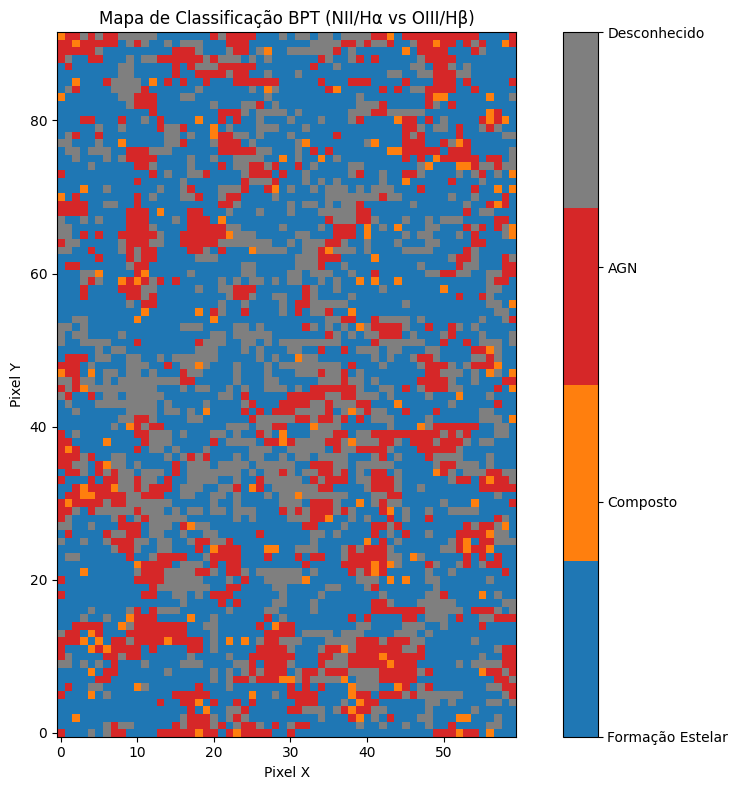

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# --- Funções para ajuste gaussiano ---
def gaussian(x, amp, cen, sigma):
    return amp * np.exp(-0.5 * ((x - cen) / sigma) ** 2)

def three_gaussians(x, A1, c1, s1, A2, c2, s2, A3, c3, s3):
    return (gaussian(x, A1, c1, s1) +
            gaussian(x, A2, c2, s2) +
            gaussian(x, A3, c3, s3))

def extract_flux_single_line(spectrum, wavelengths, center_wl, window=10):
    idx_center = np.argmin(np.abs(wavelengths - center_wl))
    idx_min = max(idx_center - window, 0)
    idx_max = min(idx_center + window, len(wavelengths) - 1)
    x = wavelengths[idx_min:idx_max+1]
    y = spectrum[idx_min:idx_max+1]

    if np.all(np.isnan(y)) or np.nanmax(y) <= 0:
        return np.nan

    p0 = [np.nanmax(y), center_wl, 2.0]  # Amplitude, centro, sigma
    try:
        popt, _ = curve_fit(gaussian, x, y, p0=p0, bounds=(0, np.inf), maxfev=1000)
        amp, cen, sigma = popt
        fluxo = amp * sigma * np.sqrt(2 * np.pi)
        return fluxo
    except Exception:
        return np.nan

def extract_flux_triple_lines(spectrum, wavelengths, centers, window=15):
    center_main = centers[1]  # geralmente Hα no meio
    idx_center = np.argmin(np.abs(wavelengths - center_main))
    idx_min = max(idx_center - window, 0)
    idx_max = min(idx_center + window, len(wavelengths) - 1)
    x = wavelengths[idx_min:idx_max+1]
    y = spectrum[idx_min:idx_max+1]

    if np.all(np.isnan(y)) or np.nanmax(y) <= 0:
        return np.nan, np.nan, np.nan

    max_amp = np.nanmax(y)
    p0 = [
        max_amp/3, centers[0], 2.0,
        max_amp/3, centers[1], 2.0,
        max_amp/3, centers[2], 2.0,
    ]

    try:
        popt, _ = curve_fit(three_gaussians, x, y, p0=p0, bounds=(0, np.inf), maxfev=2000)
        flux1 = popt[0] * popt[2] * np.sqrt(2 * np.pi)
        flux2 = popt[3] * popt[5] * np.sqrt(2 * np.pi)
        flux3 = popt[6] * popt[8] * np.sqrt(2 * np.pi)
        return flux1, flux2, flux3
    except Exception:
        return np.nan, np.nan, np.nan

# --- Função de classificação BPT ---
def classify_bpt(log_n2_ha, log_o3_hb):
    if np.isnan(log_n2_ha) or np.isnan(log_o3_hb):
        return 3  # Desconhecido

    kewley = 0.61 / (log_n2_ha - 0.47) + 1.19
    kauffmann = 0.61 / (log_n2_ha - 0.05) + 1.3

    if log_o3_hb > kewley:
        return 2  # AGN
    elif log_o3_hb > kauffmann:
        return 1  # Composto
    else:
        return 0  # Formação Estelar (HII)

# --- Leitura do cubo e header ---
filename = '../ggrNGC1399.fits'
with fits.open(filename) as hdul:
    cube = hdul[0].data  # (n_wave, ny, nx)
    header = hdul[0].header

n_wave, ny, nx = cube.shape

crval = header['CRVAL3']
cdelt = header['CDELT3']
crpix = header['CRPIX3']
cunit = header.get('CUNIT3', 'Angstrom').strip().upper()

# Corrigir unidade para Angstrom (assumindo m -> Angstrom)
if cunit == 'M':
    wavelengths = (crval + (np.arange(n_wave) + 1 - crpix) * cdelt) * 1e10
elif cunit == 'ANGSTROM':
    wavelengths = crval + (np.arange(n_wave) + 1 - crpix) * cdelt
else:
    raise ValueError(f"Unidade de comprimento de onda inesperada: {cunit}")

# Redshift
z = 0.00475

# Linhas para o triplo [NII]6548, Hα, [NII]6583 (corrigidas pelo redshift)
centers_triple = tuple(np.array([6548.1, 6562.8, 6583.4]) * (1 + z))

# Linhas simples Hβ e [OIII]
centers_simple = {
    "Hb": 4861.3 * (1 + z),
    "OIII": 5006.8 * (1 + z)
}

# Inicializar arrays de fluxo
flux_Hb = np.full((ny, nx), np.nan)
flux_OIII = np.full((ny, nx), np.nan)
flux_NII_6548 = np.full((ny, nx), np.nan)
flux_Ha = np.full((ny, nx), np.nan)
flux_NII_6583 = np.full((ny, nx), np.nan)

print("Extraindo fluxos do cubo...")

for y in range(ny):
    for x in range(nx):
        spec = cube[:, y, x]

        f1, f2, f3 = extract_flux_triple_lines(spec, wavelengths, centers_triple)
        flux_NII_6548[y, x] = f1
        flux_Ha[y, x] = f2
        flux_NII_6583[y, x] = f3

        flux_Hb[y, x] = extract_flux_single_line(spec, wavelengths, centers_simple["Hb"])
        flux_OIII[y, x] = extract_flux_single_line(spec, wavelengths, centers_simple["OIII"])

print("Fluxos extraídos!")

# Cálculo das razões logarítmicas para BPT
with np.errstate(divide='ignore', invalid='ignore'):
    flux_NII_total = flux_NII_6548 + flux_NII_6583
    log_n2_ha = np.log10(flux_NII_total / flux_Ha)
    log_o3_hb = np.log10(flux_OIII / flux_Hb)

# Máscara para valores válidos
mask_valid = np.isfinite(log_n2_ha) & np.isfinite(log_o3_hb)

# Mapa de classificação BPT
bpt_map = np.full((ny, nx), 3, dtype=int)  # Inicializa como Desconhecido

for y in range(ny):
    for x in range(nx):
        if mask_valid[y, x]:
            bpt_map[y, x] = classify_bpt(log_n2_ha[y, x], log_o3_hb[y, x])

print("Classificação BPT concluída!")

# --- Plot do mapa de classificação ---
plt.figure(figsize=(10, 8))
colors = ['#1f77b4', '#ff7f0e', '#d62728', '#7f7f7f']  # Azul, Laranja, Vermelho, Cinza
cmap = ListedColormap(colors)
im = plt.imshow(bpt_map, origin='lower', cmap=cmap, vmin=0, vmax=3)
cbar = plt.colorbar(im, ticks=[0,1,2,3])
cbar.ax.set_yticklabels(['Formação Estelar', 'Composto', 'AGN', 'Desconhecido'])
plt.title('Mapa de Classificação BPT (NII/Hα vs OIII/Hβ)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.tight_layout()
plt.show()


In [37]:
import os
import numpy as np

# Cria a pasta 'resultados' se não existir
os.makedirs('resultados', exist_ok=True)

# Salvar arrays importantes
np.save('resultados/flux_Hb.npy', flux_Hb)
np.save('resultados/flux_OIII.npy', flux_OIII)
np.save('resultados/flux_NII_6548.npy', flux_NII_6548)
np.save('resultados/flux_Ha.npy', flux_Ha)
np.save('resultados/flux_NII_6583.npy', flux_NII_6583)

np.save('resultados/log_n2_ha.npy', log_n2_ha)
np.save('resultados/log_o3_hb.npy', log_o3_hb)
np.save('resultados/bpt_map.npy', bpt_map)
np.save('resultados/mask_valid.npy', mask_valid)

print("Dados salvos em 'resultados/' com sucesso!")


Dados salvos em 'resultados/' com sucesso!


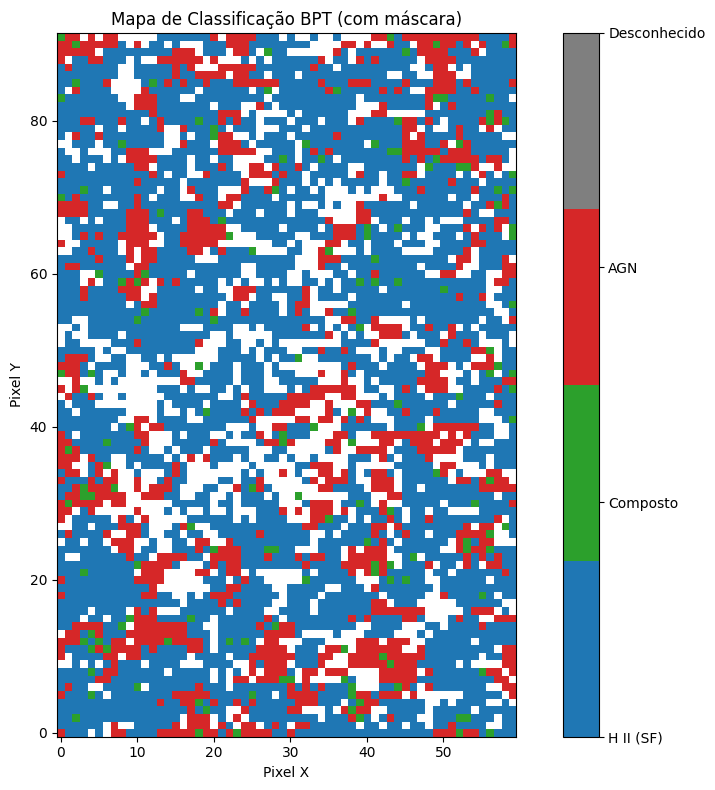

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Carregar dados salvos
flux_Hb = np.load('resultados/flux_Hb.npy')
flux_OIII = np.load('resultados/flux_OIII.npy')
flux_NII_6548 = np.load('resultados/flux_NII_6548.npy')
flux_Ha = np.load('resultados/flux_Ha.npy')
flux_NII_6583 = np.load('resultados/flux_NII_6583.npy')

log_n2_ha = np.load('resultados/log_n2_ha.npy')
log_o3_hb = np.load('resultados/log_o3_hb.npy')
bpt_map = np.load('resultados/bpt_map.npy')
mask_valid = np.load('resultados/mask_valid.npy')

# Agora você pode usar as funções de plot que criou
# Exemplo simples para visualizar o mapa BPT com máscara

colors = ['#1f77b4', '#2ca02c', '#d62728', '#7f7f7f']  # azul, verde, vermelho, cinza
labels = ['H II (SF)', 'Composto', 'AGN', 'Desconhecido']
cmap = ListedColormap(colors)

bpt_masked = bpt_map.astype(float).copy()
bpt_masked[~mask_valid] = np.nan

plt.figure(figsize=(10, 8))
im = plt.imshow(bpt_masked, origin='lower', cmap=cmap, vmin=0, vmax=3)
cbar = plt.colorbar(im, ticks=[0,1,2,3])
cbar.ax.set_yticklabels(labels)
plt.title('Mapa de Classificação BPT (com máscara)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.tight_layout()
plt.show()


Imagem salva: mapa_bpt_masked.png


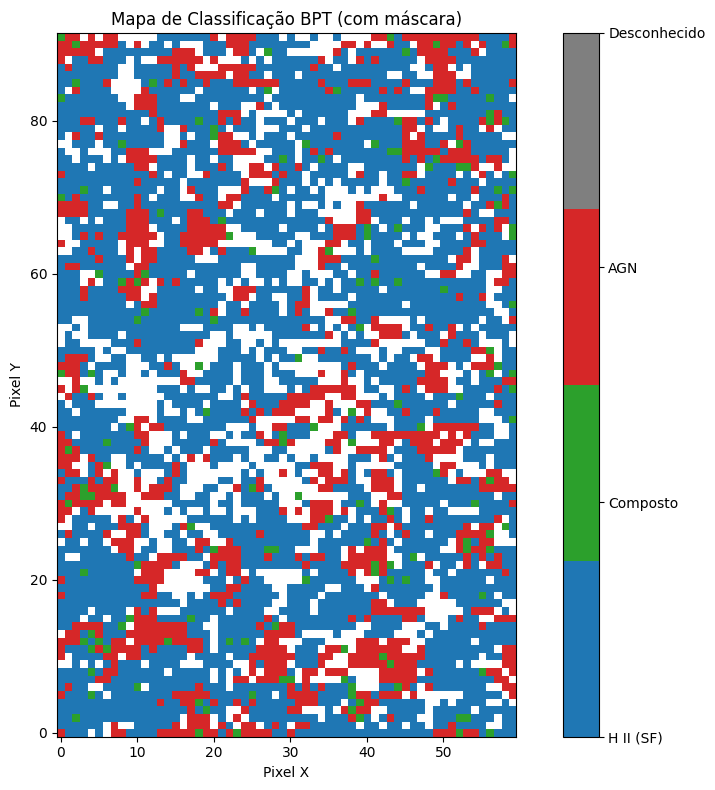

Imagem salva: diagrama_bpt_classes.png


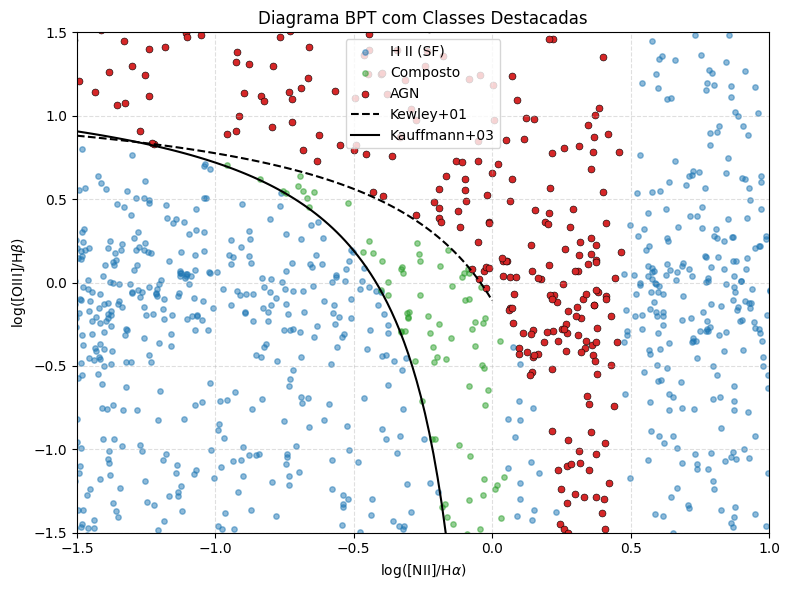

Imagem salva: imagem_integrada_cubo.png


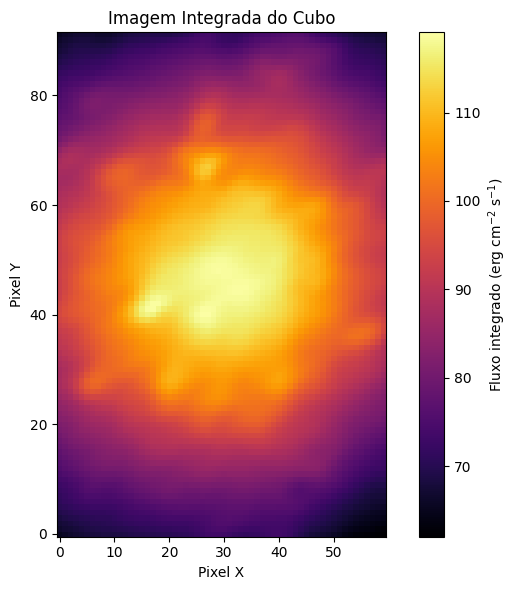

Imagem salva: canal_espectral_3126.png


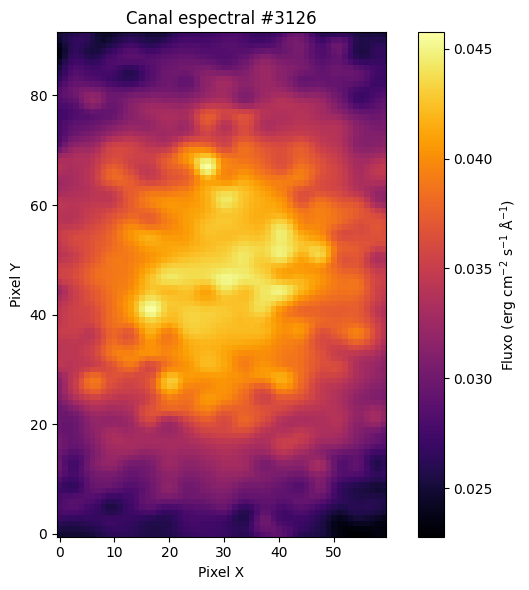

Imagem salva: espectro_pixel_50_50.png


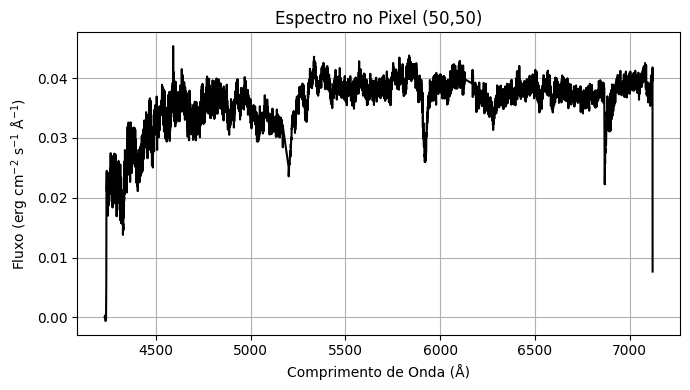

Imagem salva: mapa_bpt_sobre_imagem_integrada.png


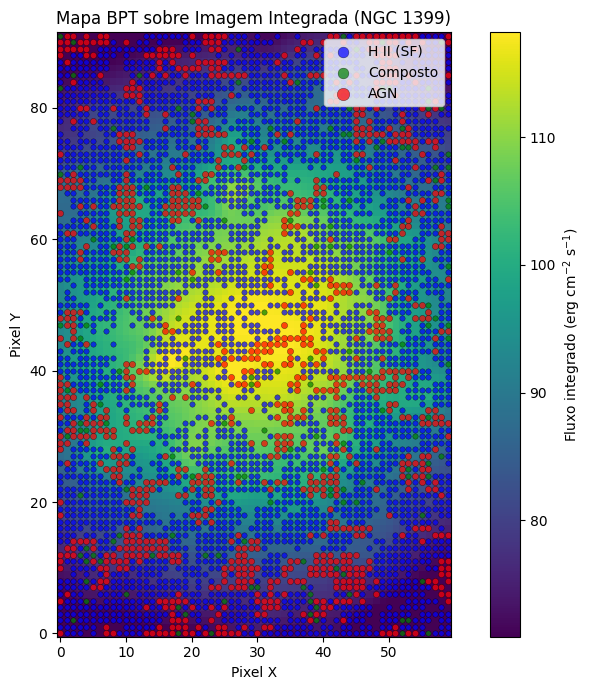

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from astropy.io import fits

def save_and_show_fig(filename):
    plt.savefig(filename, dpi=150)
    print(f"Imagem salva: {filename}")
    plt.show()
    # plt.close()  # opcional, use se quiser liberar memória imediatamente

def plot_bpt_masked(bpt_map, mask_valid):
    bpt_masked = bpt_map.astype(float).copy()
    bpt_masked[~mask_valid] = np.nan

    colors = ['#1f77b4', '#2ca02c', '#d62728', '#7f7f7f']  # azul, verde, vermelho, cinza
    labels = ['H II (SF)', 'Composto', 'AGN', 'Desconhecido']
    cmap = ListedColormap(colors)

    plt.figure(figsize=(10, 8))
    im = plt.imshow(bpt_masked, origin='lower', cmap=cmap, vmin=0, vmax=3)
    cbar = plt.colorbar(im, ticks=[0,1,2,3])
    cbar.ax.set_yticklabels(labels)
    plt.title('Mapa de Classificação BPT (com máscara)')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.tight_layout()

    save_and_show_fig('mapa_bpt_masked.png')

def plot_bpt_diagram(log_n2_ha, log_o3_hb, bpt_map, mask_valid, x_kewley, kewley_curve, x_kauff, kauffmann_curve):
    mask_sf = (bpt_map == 0) & mask_valid
    mask_comp = (bpt_map == 1) & mask_valid
    mask_agn = (bpt_map == 2) & mask_valid

    plt.figure(figsize=(8,6))
    plt.scatter(log_n2_ha[mask_sf], log_o3_hb[mask_sf], c='#1f77b4', s=15, alpha=0.5, label='H II (SF)')
    plt.scatter(log_n2_ha[mask_comp], log_o3_hb[mask_comp], c='#2ca02c', s=15, alpha=0.5, label='Composto')
    plt.scatter(log_n2_ha[mask_agn], log_o3_hb[mask_agn], c='#d62728', s=25, edgecolors='k', linewidth=0.4, label='AGN', marker='o')

    plt.plot(x_kewley, kewley_curve, 'k--', label='Kewley+01')
    plt.plot(x_kauff, kauffmann_curve, 'k-', label='Kauffmann+03')

    plt.xlabel(r'$\log([\mathrm{NII}]/\mathrm{H}\alpha)$')
    plt.ylabel(r'$\log([\mathrm{OIII}]/\mathrm{H}\beta)$')
    plt.title('Diagrama BPT com Classes Destacadas')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xlim(-1.5, 1.0)
    plt.ylim(-1.5, 1.5)
    plt.legend(loc='best', frameon=True)
    plt.tight_layout()

    save_and_show_fig('diagrama_bpt_classes.png')

def plot_img_integrada(cube, delta_lambda):
    img_integrada = np.nansum(cube, axis=0) * delta_lambda

    plt.figure(figsize=(7,6))
    plt.imshow(img_integrada, origin='lower', cmap='inferno')
    plt.colorbar(label="Fluxo integrado (erg cm$^{-2}$ s$^{-1}$)")
    plt.title("Imagem Integrada do Cubo")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.tight_layout()

    save_and_show_fig('imagem_integrada_cubo.png')

def plot_canal_espectral(cube, canal_idx):
    plt.figure(figsize=(7,6))
    plt.imshow(cube[canal_idx, :, :], origin='lower', cmap='inferno')
    plt.colorbar(label="Fluxo (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)")
    plt.title(f"Canal espectral #{canal_idx}")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.tight_layout()

    save_and_show_fig(f'canal_espectral_{canal_idx}.png')

def plot_espectro_pixel(cube, wavelengths, x0, y0):
    espectro = cube[:, y0, x0]

    plt.figure(figsize=(7,4))
    plt.plot(wavelengths, espectro, color='k')
    plt.title(f"Espectro no Pixel ({x0},{y0})")
    plt.xlabel("Comprimento de Onda (Å)")
    plt.ylabel("Fluxo (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)")
    plt.grid(True)
    plt.tight_layout()

    save_and_show_fig(f'espectro_pixel_{x0}_{y0}.png')

def plot_bpt_overlay(img_integrada, bpt_map, mask_valid):
    mask_sf = (bpt_map == 0) & mask_valid
    mask_comp = (bpt_map == 1) & mask_valid
    mask_agn = (bpt_map == 2) & mask_valid

    plt.figure(figsize=(8,7))
    vmin = np.percentile(img_integrada, 5)
    vmax = np.percentile(img_integrada, 99)
    im = plt.imshow(img_integrada, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im)
    cbar.set_label("Fluxo integrado (erg cm$^{-2}$ s$^{-1}$)")

    y_sf, x_sf = np.where(mask_sf)
    y_comp, x_comp = np.where(mask_comp)
    y_agn, x_agn = np.where(mask_agn)

    plt.scatter(x_sf, y_sf, s=15, c='blue', edgecolors='k', linewidth=0.3, label='H II (SF)', alpha=0.7)
    plt.scatter(x_comp, y_comp, s=15, c='green', edgecolors='k', linewidth=0.3, label='Composto', alpha=0.7)
    plt.scatter(x_agn, y_agn, s=20, c='red', edgecolors='k', linewidth=0.3, label='AGN', alpha=0.7)

    plt.title("Mapa BPT sobre Imagem Integrada (NGC 1399)")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.legend(markerscale=2, loc='upper right', frameon=True)
    plt.tight_layout()

    save_and_show_fig('mapa_bpt_sobre_imagem_integrada.png')


# ===================== USO =====================

filename = '../ggrNGC1399.fits'
x_pixel = 50
y_pixel = 50
canal_central = None  # Se None, calcula central automático

with fits.open(filename) as hdul:
    cube = hdul[0].data
    header = hdul[0].header

if canal_central is None:
    canal_central = cube.shape[0] // 2

delta_lambda = 0.462598  # Ajuste conforme seu header

# Atenção: Você deve ter as variáveis abaixo já calculadas e no ambiente:
# bpt_map, mask_valid, log_n2_ha, log_o3_hb

# Assumindo que você também extraiu wavelengths (em Angstrom)
crval = header['CRVAL3']
cdelt = header['CDELT3']
crpix = header['CRPIX3']
cunit = header.get('CUNIT3', 'Angstrom').strip().upper()

if cunit == 'M':
    wavelengths = (crval + (np.arange(cube.shape[0]) + 1 - crpix) * cdelt) * 1e10
elif cunit == 'ANGSTROM':
    wavelengths = crval + (np.arange(cube.shape[0]) + 1 - crpix) * cdelt
else:
    raise ValueError(f"Unidade de comprimento de onda inesperada: {cunit}")

# Calcular imagem integrada
img_integrada = np.nansum(cube, axis=0) * delta_lambda

# Executar os plots
plot_bpt_masked(bpt_map, mask_valid)
plot_bpt_diagram(log_n2_ha, log_o3_hb, bpt_map, mask_valid, x_kewley, kewley_curve, x_kauff, kauffmann_curve)
plot_img_integrada(cube, delta_lambda)
plot_canal_espectral(cube, canal_central)
plot_espectro_pixel(cube, wavelengths, x_pixel, y_pixel)
plot_bpt_overlay(img_integrada, bpt_map, mask_valid)
